# August 17th, 2018
## Benjamin Adam Catching
## Polio-virus DIPs Project
## Andino Lab

Code has now been integrated into the Microfluidics_analysis file, now apply it to all cells of the conditions:  
* P1 and DIP in Optiprep (condition 1)  
* PI and DIP not in Optiprep (condition 2)  
* Just DIP in Optiprep (condition 3)

In [1]:
# Import necessary packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import skimage
import skimage.filters
import skimage.measure
import skimage.segmentation
import skimage.feature
import scipy.ndimage as ndi
import scipy
import pandas as pd
import os

In [2]:
# Define the location of the files
bulk_cell_dir = 'data/07.27_HeLa_TIP_Hong/'

# Define the six directories that contain image files
set_1 = '#1/10x-[0-9].tif'
set_2 = '#2/10x-[0-9].tif'
set_3 = '#3/10x-[0-9].tif'

In [3]:
# Read in the files
group_1 = sorted(glob.glob(bulk_cell_dir + set_1))
group_2 = sorted(glob.glob(bulk_cell_dir + set_2))
group_3 = sorted(glob.glob(bulk_cell_dir + set_3))

In [5]:
# Import the processing script
from tools import microfluidics_analysis as ma

In [40]:
# Get the bright-field and gfp channels group 1
def droplet_save(file_list):
    """
    From a list of file names, process the file images for droplet info
    and return a list of numpy arrays representing the bright-field 
    channel and a list numpy arrays representing the GFP channel.
    
    Parameters
    ----------
    file_list:
        A list of file paths to the multi-channel image files
        
    Return
    ------
    output_bright:
        A list of 2-D, 8-bit numpy arrays representing the bright-field
        channel
    
    output_gfp:
        A list of 2-D, 8-bit numpy arrays representing the GFP channel
    """
    
    # Initialize the two output lists
    output_bright = []
    output_gfp = []
    # Iterate over the list of image paths
    for i in range(len(file_list)):
        # Segment the droplets into lists of two channels
        channels = ma.get_10x_droplets(file_list[i])
        # Assign the two lists to the two appropriate channels
        group_i_b = channels[0]
        group_i_g = channels[1]
        # Add the images to the set output file
        for j, image in enumerate(group_i_b):
            output_bright.append(image)
            output_gfp.append(group_i_g[j])
    
    return output_bright, output_gfp

In [42]:
group_1_bright, group_1_gfp = droplet_save(group_1)
group_2_bright, group_2_gfp = droplet_save(group_2)
group_3_bright, group_3_gfp = droplet_save(group_3)

print(len(group_1_bright))
print(len(group_2_bright))
print(len(group_3_bright))

477
413
407


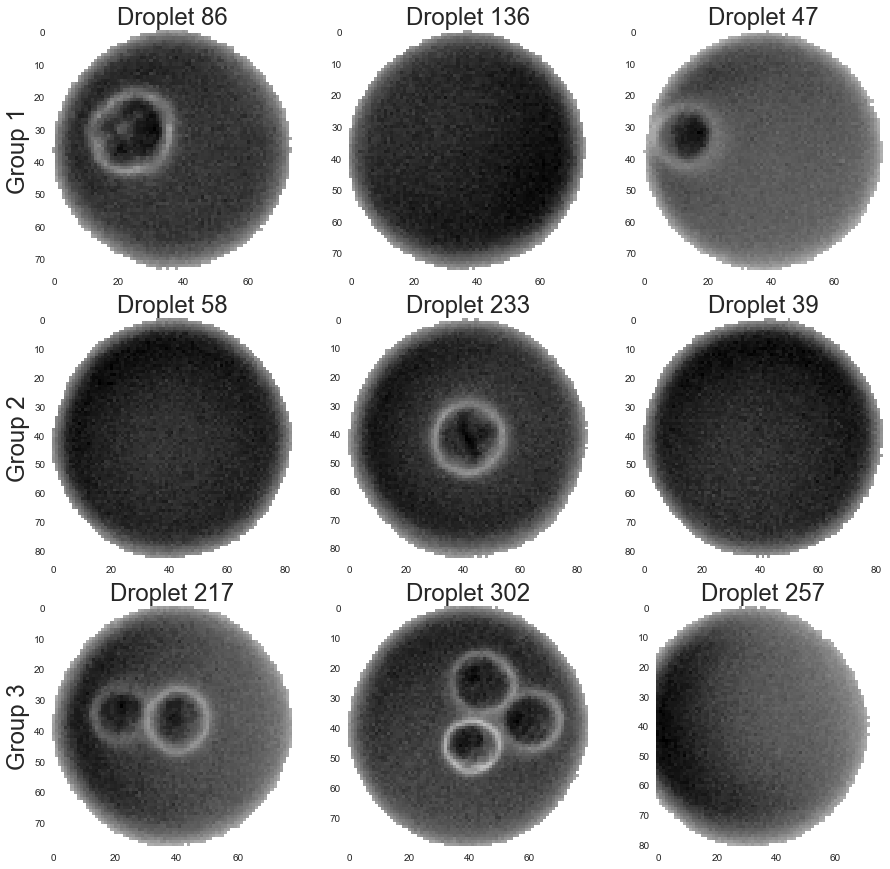

In [51]:
# Look at a test set of the droplets
rand_droplet_nums = np.empty((3, 3))
with sns.axes_style('dark'):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(3):
        ax[i, 0].set_ylabel(f"Group {i+1}", size=24)
        for j in range(3):
            if i == 0:
                rand_droplet = np.random.randint(len(group_1_bright))
                ax[0, j].imshow(group_1_bright[rand_droplet])
            elif i == 1:
                rand_droplet = np.random.randint(len(group_2_bright))
                ax[1, j].imshow(group_2_bright[rand_droplet])
            elif i == 2:
                rand_droplet = np.random.randint(len(group_3_bright))
                ax[2, j].imshow(group_3_bright[rand_droplet])
            ax[i, j].set_title(f'Droplet {rand_droplet}', size=24)
            rand_droplet_nums[i, j] = int(rand_droplet)
    plt.show()

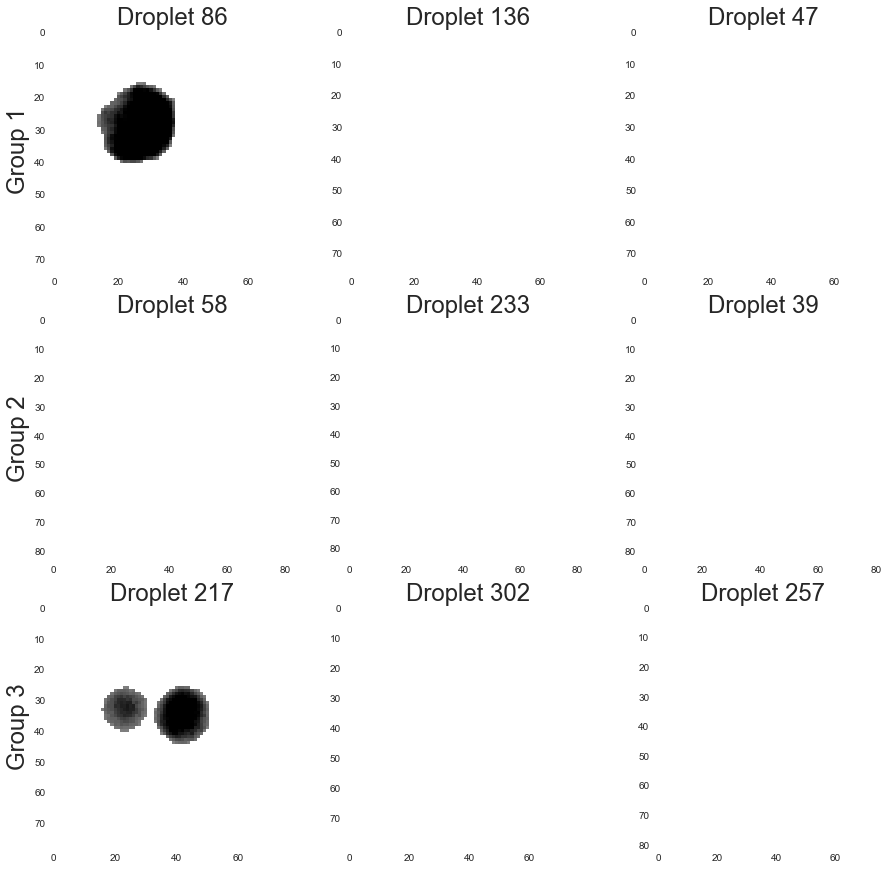

In [57]:
# Look at the GFP channel for the three groups
with sns.axes_style('dark'):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(3):
        ax[i, 0].set_ylabel(f'Group {i+1}', size=24)
        for j in range(3):
            drop_num = int(rand_droplet_nums[i, j])
            if i == 0:
                ax[0, j].imshow(group_1_gfp[drop_num])
            elif i == 1:
                ax[1, j].imshow(group_2_gfp[drop_num])
            elif i == 2:
                ax[2, j].imshow(group_3_gfp[drop_num])
            ax[i, j].set_title(f'Droplet {drop_num}', size=24)
    plt.show()

All three groups appear to be processed into droplets of appropriate size. Now process all the droplets for cells.

In [58]:
# Process the droplets
def segment_and_store(drop_bright, drop_gfp):
    """
    
    :return: 
    """
    cell_bright = []
    cell_gfp = []
    
    for index, droplet in enumerate(drop_bright):
        # Get the cells in the droplet
        temp_bw_cell, temp_gfp_cell = ma.cell_segment_10x(droplet, 
                                                          drop_gfp[index])
        cell_bright.append(temp_bw_cell)
        cell_gfp.append(temp_gfp_cell)
        
    return cell_bright, cell_gfp

In [59]:
group_1_bright_cells, group_1_gfp_cells = segment_and_store(group_1_bright, 
                                                            group_1_gfp)

4
0
1
2
3
2
0
1
6
0
1
2
3
4
5
2


0
1
3
0
1
2


2
0
1
3
0
1
2
2
0
1
3
0
1
2


6
0
1
2
3
4
5
7
0
1
2
3
4
5
6
4
0
1
2
3
4
0
1
2
3
6
0
1
2
3
4
5
3
0
1
2
4
0
1
2
3
5
0
1
2
3
4
3
0
1
2
3
0
1
2
2
0
1
2
0
1


4
0
1
2
3
3
0
1
2
5
0
1
2
3
4
5
0
1
2
3
4
2
0
1
4
0
1
2
3
3
0
1
2
2
0
1
3
0
1
2
2
0
1
2
0
1


2
0
1
4
0
1
2
3
3
0
1
2
3
0
1
2
6
0
1
2
3
4
5
4
0
1
2
3
2
0
1
5
0
1
2
3
4
3
0
1
2


/Users/adam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


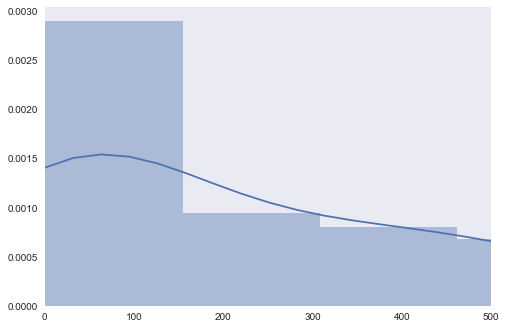

In [76]:
group_1_pixel_areas = []
for cell in group_1_bright_cells:
    if cell is not None :
        for c in cell:
            pix_area = np.sum(c != 0)
            group_1_pixel_areas.append(pix_area)
            
with sns.axes_style('dark'):
    sns.distplot(group_1_pixel_areas, norm_hist=False, )
    plt.xlim((0, 500))
    plt.show()

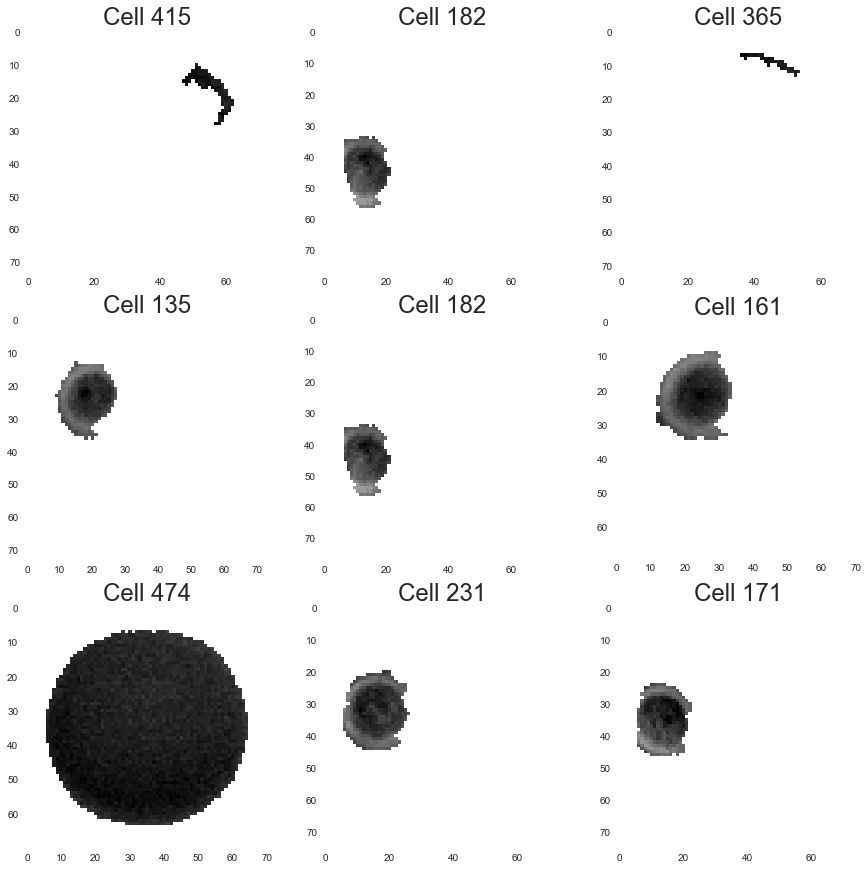

In [75]:
# Look at cells themself
with sns.axes_style('dark'):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(3):
        for j in range(3):
            good = False
            while good == False:
                random_cell = int(np.random.randint(len(group_1_bright_cells)))
                cell = group_1_bright_cells[random_cell]
                if cell is not None:
                    good = True
            ax[i, j].imshow(group_1_bright_cells[random_cell][0])
            ax[i, j].set_title(f'Cell {random_cell}', size=24)
    plt.show()

There is an error in how the cells are being segmented, 